In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import argparse
import pickle as pkl
import time
from copy import deepcopy

from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn.functional as F
from torchvision.transforms import v2
torch.manual_seed(19)

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

In [2]:
transforms = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPerspective(0.4),
    v2.ToDtype(torch.float32)
])


class NMINSTImageDataset(Dataset):
    def __init__(self, img_dir_file, transform=None, target_transform=None):
        self.images1 = np.load(img_dir_file + 'train_MNIST_Voxel1_exp_x_resolution.npy').astype(np.float32)
        self.labels1 = np.load(img_dir_file + 'train_MNIST_Voxel1_exp_y_resolution.npy')
        self.images2 = np.load(img_dir_file + 'train_MNIST_Voxel2_exp_x_resolution.npy').astype(np.float32)
        self.labels2 = np.load(img_dir_file + 'train_MNIST_Voxel2_exp_y_resolution.npy')
        self.images3 = np.load(img_dir_file + 'train_MNIST_Voxel3_exp_x_resolution.npy').astype(np.float32)
        self.labels3 = np.load(img_dir_file + 'train_MNIST_Voxel3_exp_y_resolution.npy')

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels1) + len(self.labels2) + len(self.labels3)

    def __getitem__(self, idx):
        if idx//10000 == 0:
            image = self.images1[idx%10000]
            label = self.labels1[idx%10000]
        elif idx//10000 == 1:
            image = self.images2[idx%10000]
            label = self.labels2[idx%10000]
        elif idx//10000 == 2:
            image = self.images3[idx%10000]
            label = self.labels3[idx%10000]

        label_temp = np.zeros((10,))
        label_temp[label] = 1
        if self.stage == 0:
            return self.transform(torch.tensor(image)), torch.tensor(label_temp)
        else:
            return torch.tensor(image), torch.tensor(label_temp)
        
    def set_stage(self, stage):
        self.stage = stage

In [3]:
from torch.utils.data import DataLoader
data = NMINSTImageDataset("Datasety/", transform=transforms)
generator1 = torch.Generator().manual_seed(42)
test_data, training_data = torch.utils.data.random_split(data, [0.3, 0.7], generator=generator1)

del data

In [4]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, end_maxpool = False):
        super(ResidualBlock, self).__init__()
        if(downsample is not None):
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False),
                            nn.MaxPool2d(kernel_size=2, stride=2)
                            )  # Changed inplace to False
        else:
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False)
                            )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False))  # Changed inplace to False
        self.downsample = downsample
        self.relu = nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False)  # Changed inplace to False
        self.out_channels = out_channels
        self.end_maxpool = end_maxpool

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        if self.end_maxpool:
            out = F.relu(out, inplace=False)
        else:
            out = F.hardtanh(out, inplace=False, min_val=-1.0, max_val=1.0)   # Use non-in-place ReLU
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 2, in_chanels = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_chanels, 64, kernel_size = 7, stride = 1, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=False))
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2, end_maxpool = True)
        self.avgpool = nn.MaxPool2d(7, stride=1)
        self.fc = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1, end_maxpool = False):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, padding='same'),
                nn.BatchNorm2d(planes),
                nn.ReLU(inplace=False),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            if i == blocks-1 and end_maxpool:
                layers.append(block(self.inplanes, planes, end_maxpool = True))
            else:
                layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.hardtanh(x)
        x = self.fc2(x)
        return x
    
    def train_model(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.001, save_best = False, save_thr = 0.94):
        best_accuracy = 0.0
        total_step = len(train_loader)
        train_accuracy_h = []
        test_accuracy_h = []
        train_loss_h = []
        test_loss_h = []
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)#LinearLR(optimizer,  start_factor=start_factor, end_factor=end_factor, total_iters=total_iters)
        for epoch in range(num_epochs):
            # self.train()
            correct = 0
            total = 0
            running_loss = 0.0
            train_loader.dataset.dataset.set_stage(0)
            for i, (images, labels) in enumerate(tqdm(train_loader)):
                # Move tensors to the configured device
                images = images.float().to("cuda")
                labels = labels.type(torch.FloatTensor)
                labels = labels.to("cuda")


                optimizer.zero_grad()

                # Forward pass
                outputs = self.forward(images)
                loss = criterion(outputs, labels)
                # Backward and optimize
                loss.backward()
                
                optimizer.step()

                # accuracy
                _, predicted = torch.max(outputs.data, 1)
                correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                total += labels.size(0)
                running_loss += loss.item()
                del images, labels, outputs
            train_accuracy_h.append((float(correct))/total)
            train_loss_h.append(running_loss/len(train_loader))
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
                            .format(epoch+1, num_epochs, i+1, total_step, running_loss/len(train_loader), (float(correct))/total))

            scheduler.step()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Validation
            with torch.no_grad():
                correct = 0
                total = 0
                val_loss = 0.0
                valid_loader.dataset.dataset.set_stage(1)
                for images, labels in valid_loader:
                    images = images.float().to("cuda")
                    labels = labels.type(torch.FloatTensor)
                    labels = labels.to("cuda")
                    outputs = self.forward(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    del images, labels, outputs
                if(((100 * correct / total) > best_accuracy) and save_best and ((100 * correct / total) > save_thr)):
                    torch.save(self.state_dict(), "best_resnet50_MINST-DVS_Hardtanh_ReLUmaxpool__128x128_FC2_128x128_pretrained_aug_corrected.pt")
                test_accuracy_h.append((float(correct))/total)
                test_loss_h.append(val_loss/len(valid_loader))
                print('Accuracy of the network: {} Loss: {}'.format( correct / total, val_loss/len(valid_loader)))
        return train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h

In [18]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
model_resnet = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes = 10, in_chanels=5).to("cuda")
print(model_resnet)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(5, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (relu): Hardtanh(min_val=-1.0, max_val=1.0)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kerne

### Copy weights

In [19]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)

Using cache found in C:\Users\nikos/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:

size_layer = [3, 4, 6, 3]
layers = [(model_resnet.layer0, model.layer1), (model_resnet.layer1, model.layer2), (model_resnet.layer2, model.layer3), (model_resnet.layer3, model.layer4)]
for n in range(len(layers)):
    for i in range(size_layer[n]):
        layers[n][0][i].conv1[0] = layers[n][1][i].conv1
        layers[n][0][i].conv1[0].stride = 1
        layers[n][0][i].conv2[0] = layers[n][1][i].conv2
        layers[n][0][i].conv2[0].stride = 1
        
        layers[n][0][i].conv1[1] = layers[n][1][i].bn1
        layers[n][0][i].conv2[1] = layers[n][1][i].bn2

model_resnet.layer1[0].downsample[0] = model.layer2[0].downsample[0]
model_resnet.layer1[0].downsample[0].stride = 1
model_resnet.layer1[0].downsample[1] = model.layer2[0].downsample[1]

model_resnet.layer2[0].downsample[0] = model.layer3[0].downsample[0]
model_resnet.layer2[0].downsample[0].stride = 1
model_resnet.layer2[0].downsample[1] = model.layer3[0].downsample[1]

model_resnet.layer3[0].downsample[0] = model.layer4[0].downsample[0]
model_resnet.layer3[0].downsample[0].stride = 1
model_resnet.layer3[0].downsample[1] = model.layer4[0].downsample[1]

model_resnet.to("cuda")

ResNet(
  (conv1): Sequential(
    (0): Conv2d(5, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (relu): Hardtanh(min_val=-1.0, max_val=1.0)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv

In [21]:
torch.autograd.set_detect_anomaly(True)
train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h = model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=120,save_best=True, save_thr=90)

100%|██████████| 657/657 [03:40<00:00,  2.97it/s]


Epoch [1/120], Step [657/657], Loss: 2.8097, Accuracy: 0.1229
Accuracy of the network: 0.12655555555555556 Loss: 2.434055821269962


100%|██████████| 657/657 [03:36<00:00,  3.03it/s]


Epoch [2/120], Step [657/657], Loss: 2.1698, Accuracy: 0.1887
Accuracy of the network: 0.1628888888888889 Loss: 3.2771811688199954


100%|██████████| 657/657 [03:41<00:00,  2.97it/s]


Epoch [3/120], Step [657/657], Loss: 1.7895, Accuracy: 0.2831
Accuracy of the network: 0.312 Loss: 1.698019635170064


100%|██████████| 657/657 [03:37<00:00,  3.02it/s]


Epoch [4/120], Step [657/657], Loss: 1.2362, Accuracy: 0.5225
Accuracy of the network: 0.6233333333333333 Loss: 1.0459951065110822


100%|██████████| 657/657 [03:44<00:00,  2.92it/s]


Epoch [5/120], Step [657/657], Loss: 0.8895, Accuracy: 0.6715
Accuracy of the network: 0.6137777777777778 Loss: 1.0157403713422464


100%|██████████| 657/657 [03:43<00:00,  2.94it/s]


Epoch [6/120], Step [657/657], Loss: 0.7852, Accuracy: 0.7112
Accuracy of the network: 0.788 Loss: 0.6295181847844563


100%|██████████| 657/657 [03:36<00:00,  3.04it/s]


Epoch [7/120], Step [657/657], Loss: 0.7286, Accuracy: 0.7387
Accuracy of the network: 0.7156666666666667 Loss: 0.8048409212988319


100%|██████████| 657/657 [03:40<00:00,  2.98it/s]


Epoch [8/120], Step [657/657], Loss: 0.6828, Accuracy: 0.7619
Accuracy of the network: 0.8002222222222222 Loss: 0.5877148875742094


100%|██████████| 657/657 [03:35<00:00,  3.04it/s]


Epoch [9/120], Step [657/657], Loss: 0.6307, Accuracy: 0.7790
Accuracy of the network: 0.8482222222222222 Loss: 0.4641433728607834


100%|██████████| 657/657 [03:35<00:00,  3.05it/s]


Epoch [10/120], Step [657/657], Loss: 0.6041, Accuracy: 0.7902
Accuracy of the network: 0.8184444444444444 Loss: 0.5635512288369185


100%|██████████| 657/657 [03:34<00:00,  3.06it/s]


Epoch [11/120], Step [657/657], Loss: 0.5613, Accuracy: 0.8077
Accuracy of the network: 0.8576666666666667 Loss: 0.45054012484161565


100%|██████████| 657/657 [03:34<00:00,  3.06it/s]


Epoch [12/120], Step [657/657], Loss: 0.5338, Accuracy: 0.8197
Accuracy of the network: 0.8445555555555555 Loss: 0.4698904103315468


100%|██████████| 657/657 [03:40<00:00,  2.98it/s]


Epoch [13/120], Step [657/657], Loss: 0.5024, Accuracy: 0.8343
Accuracy of the network: 0.8556666666666667 Loss: 0.45680079619723857


100%|██████████| 657/657 [03:46<00:00,  2.89it/s]


Epoch [14/120], Step [657/657], Loss: 0.4753, Accuracy: 0.8448
Accuracy of the network: 0.8503333333333334 Loss: 0.4452411063702394


100%|██████████| 657/657 [03:46<00:00,  2.90it/s]


Epoch [15/120], Step [657/657], Loss: 0.4665, Accuracy: 0.8457
Accuracy of the network: 0.8771111111111111 Loss: 0.39250841948157505


100%|██████████| 657/657 [03:46<00:00,  2.90it/s]


Epoch [16/120], Step [657/657], Loss: 0.4515, Accuracy: 0.8501
Accuracy of the network: 0.8761111111111111 Loss: 0.38754168929571803


100%|██████████| 657/657 [03:37<00:00,  3.02it/s]


Epoch [17/120], Step [657/657], Loss: 0.4371, Accuracy: 0.8540
Accuracy of the network: 0.8671111111111112 Loss: 0.40538197444051716


100%|██████████| 657/657 [03:34<00:00,  3.06it/s]


Epoch [18/120], Step [657/657], Loss: 0.4097, Accuracy: 0.8681
Accuracy of the network: 0.8897777777777778 Loss: 0.3577765577756767


100%|██████████| 657/657 [03:33<00:00,  3.07it/s]


Epoch [19/120], Step [657/657], Loss: 0.3963, Accuracy: 0.8711
Accuracy of the network: 0.8967777777777778 Loss: 0.3378055823821548


100%|██████████| 657/657 [03:34<00:00,  3.07it/s]


Epoch [20/120], Step [657/657], Loss: 0.3835, Accuracy: 0.8777
Accuracy of the network: 0.8903333333333333 Loss: 0.35034833309498237


100%|██████████| 657/657 [03:28<00:00,  3.16it/s]


Epoch [21/120], Step [657/657], Loss: 0.3753, Accuracy: 0.8805
Accuracy of the network: 0.9082222222222223 Loss: 0.31454102776891796


100%|██████████| 657/657 [03:28<00:00,  3.15it/s]


Epoch [22/120], Step [657/657], Loss: 0.3632, Accuracy: 0.8856
Accuracy of the network: 0.9162222222222223 Loss: 0.29670235641459203


100%|██████████| 657/657 [03:37<00:00,  3.02it/s]


Epoch [23/120], Step [657/657], Loss: 0.3527, Accuracy: 0.8888
Accuracy of the network: 0.9134444444444444 Loss: 0.28709338288357916


100%|██████████| 657/657 [03:32<00:00,  3.09it/s]


Epoch [24/120], Step [657/657], Loss: 0.3384, Accuracy: 0.8960
Accuracy of the network: 0.9034444444444445 Loss: 0.31585822275555725


100%|██████████| 657/657 [03:32<00:00,  3.09it/s]


Epoch [25/120], Step [657/657], Loss: 0.3271, Accuracy: 0.8989
Accuracy of the network: 0.9196666666666666 Loss: 0.2744333520795859


100%|██████████| 657/657 [03:32<00:00,  3.09it/s]


Epoch [26/120], Step [657/657], Loss: 0.3099, Accuracy: 0.9030
Accuracy of the network: 0.925 Loss: 0.2594848902671472


100%|██████████| 657/657 [03:29<00:00,  3.14it/s]


Epoch [27/120], Step [657/657], Loss: 0.3014, Accuracy: 0.9080
Accuracy of the network: 0.9265555555555556 Loss: 0.2508948916926029


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [28/120], Step [657/657], Loss: 0.2945, Accuracy: 0.9091
Accuracy of the network: 0.9213333333333333 Loss: 0.2722247377936299


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [29/120], Step [657/657], Loss: 0.2828, Accuracy: 0.9145
Accuracy of the network: 0.9257777777777778 Loss: 0.24952657800828312


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [30/120], Step [657/657], Loss: 0.2687, Accuracy: 0.9163
Accuracy of the network: 0.9341111111111111 Loss: 0.2313920324073827


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [31/120], Step [657/657], Loss: 0.2648, Accuracy: 0.9196
Accuracy of the network: 0.9417777777777778 Loss: 0.2063371913362268


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [32/120], Step [657/657], Loss: 0.2572, Accuracy: 0.9228
Accuracy of the network: 0.9368888888888889 Loss: 0.21653359869481825


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [33/120], Step [657/657], Loss: 0.2540, Accuracy: 0.9232
Accuracy of the network: 0.9372222222222222 Loss: 0.2127743940404121


100%|██████████| 657/657 [03:26<00:00,  3.19it/s]


Epoch [34/120], Step [657/657], Loss: 0.2436, Accuracy: 0.9260
Accuracy of the network: 0.9422222222222222 Loss: 0.20715550755989467


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [35/120], Step [657/657], Loss: 0.2313, Accuracy: 0.9305
Accuracy of the network: 0.9454444444444444 Loss: 0.19198147031802235


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [36/120], Step [657/657], Loss: 0.2273, Accuracy: 0.9310
Accuracy of the network: 0.9496666666666667 Loss: 0.18467881813222634


100%|██████████| 657/657 [03:26<00:00,  3.19it/s]


Epoch [37/120], Step [657/657], Loss: 0.2207, Accuracy: 0.9324
Accuracy of the network: 0.948 Loss: 0.1855743104023925


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [38/120], Step [657/657], Loss: 0.2185, Accuracy: 0.9328
Accuracy of the network: 0.9431111111111111 Loss: 0.19452524852298253


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [39/120], Step [657/657], Loss: 0.2186, Accuracy: 0.9344
Accuracy of the network: 0.9406666666666667 Loss: 0.20418194917869484


100%|██████████| 657/657 [03:26<00:00,  3.19it/s]


Epoch [40/120], Step [657/657], Loss: 0.2074, Accuracy: 0.9370
Accuracy of the network: 0.9515555555555556 Loss: 0.17521448669862663


100%|██████████| 657/657 [03:26<00:00,  3.19it/s]


Epoch [41/120], Step [657/657], Loss: 0.2092, Accuracy: 0.9368
Accuracy of the network: 0.9478888888888889 Loss: 0.1799954721202136


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [42/120], Step [657/657], Loss: 0.2061, Accuracy: 0.9392
Accuracy of the network: 0.9483333333333334 Loss: 0.17802685084389458


100%|██████████| 657/657 [03:25<00:00,  3.19it/s]


Epoch [43/120], Step [657/657], Loss: 0.2001, Accuracy: 0.9402
Accuracy of the network: 0.954 Loss: 0.16845157087271942


100%|██████████| 657/657 [03:26<00:00,  3.19it/s]


Epoch [44/120], Step [657/657], Loss: 0.1982, Accuracy: 0.9416
Accuracy of the network: 0.9526666666666667 Loss: 0.17113292890977352


100%|██████████| 657/657 [03:26<00:00,  3.19it/s]


Epoch [45/120], Step [657/657], Loss: 0.1948, Accuracy: 0.9413
Accuracy of the network: 0.9535555555555556 Loss: 0.16542513731946337


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [46/120], Step [657/657], Loss: 0.1895, Accuracy: 0.9438
Accuracy of the network: 0.953 Loss: 0.16879283920828755


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [47/120], Step [657/657], Loss: 0.1924, Accuracy: 0.9429
Accuracy of the network: 0.9533333333333334 Loss: 0.16684893520007318


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [48/120], Step [657/657], Loss: 0.1858, Accuracy: 0.9433
Accuracy of the network: 0.9575555555555556 Loss: 0.159667275713902


100%|██████████| 657/657 [03:26<00:00,  3.19it/s]


Epoch [49/120], Step [657/657], Loss: 0.1846, Accuracy: 0.9460
Accuracy of the network: 0.9546666666666667 Loss: 0.1596108013830075


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [50/120], Step [657/657], Loss: 0.1861, Accuracy: 0.9439
Accuracy of the network: 0.9545555555555556 Loss: 0.1605010629624974


100%|██████████| 657/657 [03:26<00:00,  3.19it/s]


Epoch [51/120], Step [657/657], Loss: 0.1824, Accuracy: 0.9458
Accuracy of the network: 0.956 Loss: 0.15831788630614466


100%|██████████| 657/657 [03:26<00:00,  3.19it/s]


Epoch [52/120], Step [657/657], Loss: 0.1788, Accuracy: 0.9485
Accuracy of the network: 0.9563333333333334 Loss: 0.15839471013437137


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [53/120], Step [657/657], Loss: 0.1779, Accuracy: 0.9489
Accuracy of the network: 0.9585555555555556 Loss: 0.15294449670398805


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [54/120], Step [657/657], Loss: 0.1776, Accuracy: 0.9488
Accuracy of the network: 0.9591111111111111 Loss: 0.1565241526072541


100%|██████████| 657/657 [03:25<00:00,  3.19it/s]


Epoch [55/120], Step [657/657], Loss: 0.1799, Accuracy: 0.9474
Accuracy of the network: 0.957 Loss: 0.157254205659983


100%|██████████| 657/657 [03:26<00:00,  3.19it/s]


Epoch [56/120], Step [657/657], Loss: 0.1782, Accuracy: 0.9485
Accuracy of the network: 0.9562222222222222 Loss: 0.154654276147749


100%|██████████| 657/657 [03:26<00:00,  3.19it/s]


Epoch [57/120], Step [657/657], Loss: 0.1764, Accuracy: 0.9480
Accuracy of the network: 0.956 Loss: 0.15672048194505644


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [58/120], Step [657/657], Loss: 0.1779, Accuracy: 0.9473
Accuracy of the network: 0.9578888888888889 Loss: 0.1527962668382741


100%|██████████| 657/657 [03:26<00:00,  3.19it/s]


Epoch [59/120], Step [657/657], Loss: 0.1755, Accuracy: 0.9491
Accuracy of the network: 0.959 Loss: 0.1512741498147131


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [60/120], Step [657/657], Loss: 0.1737, Accuracy: 0.9484
Accuracy of the network: 0.9578888888888889 Loss: 0.15359792847794


100%|██████████| 657/657 [03:25<00:00,  3.19it/s]


Epoch [61/120], Step [657/657], Loss: 0.1758, Accuracy: 0.9482
Accuracy of the network: 0.9564444444444444 Loss: 0.1526082613974387


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [62/120], Step [657/657], Loss: 0.1726, Accuracy: 0.9480
Accuracy of the network: 0.9596666666666667 Loss: 0.14727222893043612


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [63/120], Step [657/657], Loss: 0.1729, Accuracy: 0.9506
Accuracy of the network: 0.9591111111111111 Loss: 0.14978098295998912


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [64/120], Step [657/657], Loss: 0.1717, Accuracy: 0.9497
Accuracy of the network: 0.9576666666666667 Loss: 0.15200995341445325


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [65/120], Step [657/657], Loss: 0.1713, Accuracy: 0.9495
Accuracy of the network: 0.9576666666666667 Loss: 0.15059275659633445


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [66/120], Step [657/657], Loss: 0.1723, Accuracy: 0.9508
Accuracy of the network: 0.9593333333333334 Loss: 0.1483902117462023


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [67/120], Step [657/657], Loss: 0.1719, Accuracy: 0.9501
Accuracy of the network: 0.9594444444444444 Loss: 0.14946238964743225


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [68/120], Step [657/657], Loss: 0.1669, Accuracy: 0.9521
Accuracy of the network: 0.96 Loss: 0.14767159270585006


100%|██████████| 657/657 [03:26<00:00,  3.19it/s]


Epoch [69/120], Step [657/657], Loss: 0.1668, Accuracy: 0.9516
Accuracy of the network: 0.9594444444444444 Loss: 0.14836680676444625


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [70/120], Step [657/657], Loss: 0.1700, Accuracy: 0.9512
Accuracy of the network: 0.9587777777777777 Loss: 0.14922031008552575


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [71/120], Step [657/657], Loss: 0.1672, Accuracy: 0.9520
Accuracy of the network: 0.962 Loss: 0.14584749287773743


100%|██████████| 657/657 [03:26<00:00,  3.17it/s]


Epoch [72/120], Step [657/657], Loss: 0.1691, Accuracy: 0.9507
Accuracy of the network: 0.9577777777777777 Loss: 0.14947650534041385


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [73/120], Step [657/657], Loss: 0.1670, Accuracy: 0.9518
Accuracy of the network: 0.9578888888888889 Loss: 0.14921838979084864


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [74/120], Step [657/657], Loss: 0.1709, Accuracy: 0.9489
Accuracy of the network: 0.9592222222222222 Loss: 0.1489536283035756


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [75/120], Step [657/657], Loss: 0.1675, Accuracy: 0.9505
Accuracy of the network: 0.9602222222222222 Loss: 0.14562595131681533


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [76/120], Step [657/657], Loss: 0.1684, Accuracy: 0.9513
Accuracy of the network: 0.9594444444444444 Loss: 0.14905027295495812


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [77/120], Step [657/657], Loss: 0.1660, Accuracy: 0.9520
Accuracy of the network: 0.96 Loss: 0.14829915899334226


100%|██████████| 657/657 [03:28<00:00,  3.15it/s]


Epoch [78/120], Step [657/657], Loss: 0.1670, Accuracy: 0.9494
Accuracy of the network: 0.9585555555555556 Loss: 0.14681372232735157


100%|██████████| 657/657 [03:32<00:00,  3.09it/s]


Epoch [79/120], Step [657/657], Loss: 0.1665, Accuracy: 0.9525
Accuracy of the network: 0.9593333333333334 Loss: 0.14575564817703784


100%|██████████| 657/657 [03:33<00:00,  3.08it/s]


Epoch [80/120], Step [657/657], Loss: 0.1679, Accuracy: 0.9519
Accuracy of the network: 0.9584444444444444 Loss: 0.14585324102048333


100%|██████████| 657/657 [03:33<00:00,  3.08it/s]


Epoch [81/120], Step [657/657], Loss: 0.1666, Accuracy: 0.9500
Accuracy of the network: 0.9595555555555556 Loss: 0.1494295622506146


100%|██████████| 657/657 [03:50<00:00,  2.85it/s]


Epoch [82/120], Step [657/657], Loss: 0.1665, Accuracy: 0.9506
Accuracy of the network: 0.9598888888888889 Loss: 0.14631206538950933


100%|██████████| 657/657 [03:48<00:00,  2.87it/s]


Epoch [83/120], Step [657/657], Loss: 0.1683, Accuracy: 0.9501
Accuracy of the network: 0.9588888888888889 Loss: 0.14814528347990402


100%|██████████| 657/657 [03:42<00:00,  2.95it/s]


Epoch [84/120], Step [657/657], Loss: 0.1671, Accuracy: 0.9512
Accuracy of the network: 0.9575555555555556 Loss: 0.14995548007547432


100%|██████████| 657/657 [03:42<00:00,  2.95it/s]


Epoch [85/120], Step [657/657], Loss: 0.1682, Accuracy: 0.9510
Accuracy of the network: 0.9598888888888889 Loss: 0.145189369837126


100%|██████████| 657/657 [03:37<00:00,  3.02it/s]


Epoch [86/120], Step [657/657], Loss: 0.1674, Accuracy: 0.9515
Accuracy of the network: 0.9593333333333334 Loss: 0.14566683464069316


100%|██████████| 657/657 [03:37<00:00,  3.02it/s]


Epoch [87/120], Step [657/657], Loss: 0.1660, Accuracy: 0.9524
Accuracy of the network: 0.9596666666666667 Loss: 0.14858274812420422


100%|██████████| 657/657 [03:37<00:00,  3.02it/s]


Epoch [88/120], Step [657/657], Loss: 0.1679, Accuracy: 0.9504
Accuracy of the network: 0.9581111111111111 Loss: 0.14924160075367343


100%|██████████| 657/657 [03:37<00:00,  3.02it/s]


Epoch [89/120], Step [657/657], Loss: 0.1676, Accuracy: 0.9503
Accuracy of the network: 0.9585555555555556 Loss: 0.14796506929217923


100%|██████████| 657/657 [03:38<00:00,  3.00it/s]


Epoch [90/120], Step [657/657], Loss: 0.1701, Accuracy: 0.9505
Accuracy of the network: 0.9624444444444444 Loss: 0.1438813362970737


100%|██████████| 657/657 [03:38<00:00,  3.01it/s]


Epoch [91/120], Step [657/657], Loss: 0.1693, Accuracy: 0.9504
Accuracy of the network: 0.959 Loss: 0.14645009995140928


100%|██████████| 657/657 [02:40<00:00,  4.11it/s]


Epoch [92/120], Step [657/657], Loss: 0.1673, Accuracy: 0.9497
Accuracy of the network: 0.9613333333333334 Loss: 0.14651932890348612


100%|██████████| 657/657 [02:31<00:00,  4.33it/s]


Epoch [93/120], Step [657/657], Loss: 0.1661, Accuracy: 0.9530
Accuracy of the network: 0.9581111111111111 Loss: 0.1496270699228378


100%|██████████| 657/657 [02:30<00:00,  4.35it/s]


Epoch [94/120], Step [657/657], Loss: 0.1666, Accuracy: 0.9516
Accuracy of the network: 0.9616666666666667 Loss: 0.14374569750635335


100%|██████████| 657/657 [02:30<00:00,  4.37it/s]


Epoch [95/120], Step [657/657], Loss: 0.1659, Accuracy: 0.9524
Accuracy of the network: 0.9576666666666667 Loss: 0.14466735196187563


100%|██████████| 657/657 [02:30<00:00,  4.37it/s]


Epoch [96/120], Step [657/657], Loss: 0.1650, Accuracy: 0.9526
Accuracy of the network: 0.9606666666666667 Loss: 0.14491339741895595


100%|██████████| 657/657 [02:29<00:00,  4.40it/s]


Epoch [97/120], Step [657/657], Loss: 0.1690, Accuracy: 0.9513
Accuracy of the network: 0.9591111111111111 Loss: 0.14601982226397128


100%|██████████| 657/657 [02:29<00:00,  4.39it/s]


Epoch [98/120], Step [657/657], Loss: 0.1673, Accuracy: 0.9502
Accuracy of the network: 0.9593333333333334 Loss: 0.14639816941785896


100%|██████████| 657/657 [02:29<00:00,  4.39it/s]


Epoch [99/120], Step [657/657], Loss: 0.1658, Accuracy: 0.9513
Accuracy of the network: 0.959 Loss: 0.14607295090108052


100%|██████████| 657/657 [02:33<00:00,  4.29it/s]


Epoch [100/120], Step [657/657], Loss: 0.1652, Accuracy: 0.9510
Accuracy of the network: 0.9582222222222222 Loss: 0.14873917583798899


100%|██████████| 657/657 [02:32<00:00,  4.30it/s]


Epoch [101/120], Step [657/657], Loss: 0.1659, Accuracy: 0.9518
Accuracy of the network: 0.9584444444444444 Loss: 0.14676246308582894


100%|██████████| 657/657 [02:33<00:00,  4.27it/s]


Epoch [102/120], Step [657/657], Loss: 0.1676, Accuracy: 0.9506
Accuracy of the network: 0.958 Loss: 0.14890096577029702


100%|██████████| 657/657 [02:33<00:00,  4.29it/s]


Epoch [103/120], Step [657/657], Loss: 0.1643, Accuracy: 0.9530
Accuracy of the network: 0.9584444444444444 Loss: 0.14510171666265803


100%|██████████| 657/657 [02:34<00:00,  4.26it/s]


Epoch [104/120], Step [657/657], Loss: 0.1680, Accuracy: 0.9515
Accuracy of the network: 0.959 Loss: 0.14663943440276891


100%|██████████| 657/657 [02:32<00:00,  4.31it/s]


Epoch [105/120], Step [657/657], Loss: 0.1687, Accuracy: 0.9508
Accuracy of the network: 0.9587777777777777 Loss: 0.1484623067741487


100%|██████████| 657/657 [02:31<00:00,  4.35it/s]


Epoch [106/120], Step [657/657], Loss: 0.1652, Accuracy: 0.9523
Accuracy of the network: 0.9611111111111111 Loss: 0.1445443676586481


100%|██████████| 657/657 [02:32<00:00,  4.31it/s]


Epoch [107/120], Step [657/657], Loss: 0.1666, Accuracy: 0.9516
Accuracy of the network: 0.9577777777777777 Loss: 0.1480971062291704


100%|██████████| 657/657 [02:31<00:00,  4.35it/s]


Epoch [108/120], Step [657/657], Loss: 0.1616, Accuracy: 0.9533
Accuracy of the network: 0.9604444444444444 Loss: 0.14765747681471472


100%|██████████| 657/657 [02:32<00:00,  4.31it/s]


Epoch [109/120], Step [657/657], Loss: 0.1649, Accuracy: 0.9524
Accuracy of the network: 0.9583333333333334 Loss: 0.1471139700779467


100%|██████████| 657/657 [02:33<00:00,  4.27it/s]


Epoch [110/120], Step [657/657], Loss: 0.1621, Accuracy: 0.9514
Accuracy of the network: 0.9604444444444444 Loss: 0.147909075669046


100%|██████████| 657/657 [02:33<00:00,  4.29it/s]


Epoch [111/120], Step [657/657], Loss: 0.1657, Accuracy: 0.9528
Accuracy of the network: 0.9592222222222222 Loss: 0.14617039372893512


100%|██████████| 657/657 [02:36<00:00,  4.21it/s]


Epoch [112/120], Step [657/657], Loss: 0.1660, Accuracy: 0.9517
Accuracy of the network: 0.9598888888888889 Loss: 0.14698728293523933


100%|██████████| 657/657 [02:33<00:00,  4.29it/s]


Epoch [113/120], Step [657/657], Loss: 0.1642, Accuracy: 0.9525
Accuracy of the network: 0.9594444444444444 Loss: 0.14939112855610273


100%|██████████| 657/657 [02:32<00:00,  4.30it/s]


Epoch [114/120], Step [657/657], Loss: 0.1661, Accuracy: 0.9503
Accuracy of the network: 0.9582222222222222 Loss: 0.14942378704667303


100%|██████████| 657/657 [02:32<00:00,  4.32it/s]


Epoch [115/120], Step [657/657], Loss: 0.1618, Accuracy: 0.9538
Accuracy of the network: 0.9595555555555556 Loss: 0.1457369409316609


100%|██████████| 657/657 [02:31<00:00,  4.34it/s]


Epoch [116/120], Step [657/657], Loss: 0.1649, Accuracy: 0.9514
Accuracy of the network: 0.962 Loss: 0.14499296839778306


100%|██████████| 657/657 [02:30<00:00,  4.37it/s]


Epoch [117/120], Step [657/657], Loss: 0.1671, Accuracy: 0.9505
Accuracy of the network: 0.9594444444444444 Loss: 0.1462042822852625


100%|██████████| 657/657 [02:34<00:00,  4.26it/s]


Epoch [118/120], Step [657/657], Loss: 0.1683, Accuracy: 0.9511
Accuracy of the network: 0.9595555555555556 Loss: 0.1476511593234349


100%|██████████| 657/657 [02:34<00:00,  4.26it/s]


Epoch [119/120], Step [657/657], Loss: 0.1688, Accuracy: 0.9517
Accuracy of the network: 0.9598888888888889 Loss: 0.1465700053154154


100%|██████████| 657/657 [02:31<00:00,  4.33it/s]


Epoch [120/120], Step [657/657], Loss: 0.1672, Accuracy: 0.9502
Accuracy of the network: 0.9586666666666667 Loss: 0.14715018890903775


In [22]:
torch.save(model, "best_resnet50_MINST-DVS_Hardtanh_ReLUmaxpool_128x128_FC2_128x128_pretrained_aug_corrected.pt")


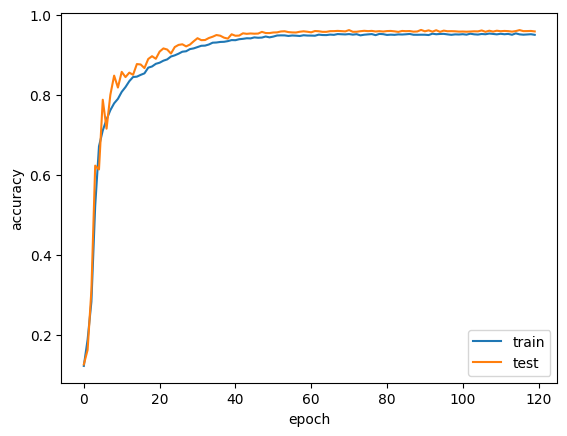

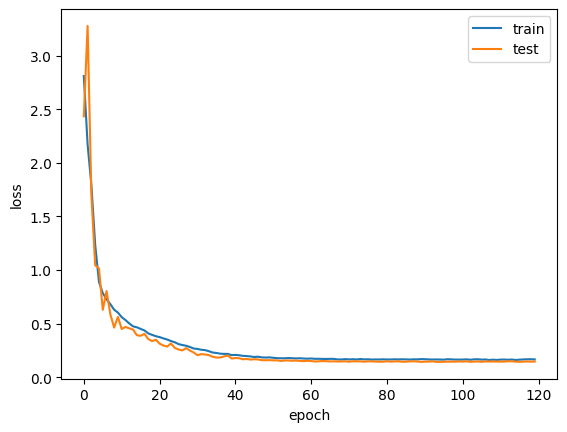

In [23]:
plt.plot(train_accuracy_h, label='train')
plt.plot(test_accuracy_h, label='test')
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

plt.plot(train_loss_h, label='train')
plt.plot(test_loss_h, label='test')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [24]:
import pandas as pd
dict = {'train_acc': train_accuracy_h, 'test_acc': test_accuracy_h, 'train_loss': train_loss_h, 'test_loss' : test_loss_h}
df = pd.DataFrame(dict)
df.to_csv('logs/best_resnet50_MINST-DVS_Hardtanh_ReLUmaxpool_128x128_FC2_128x128_pretrained_aug_corrected.csv')

In [25]:
df.head()

,train_acc,test_acc,train_loss,test_loss
0,0.122857,0.126556,2.809729,2.434056
1,0.188714,0.162889,2.169776,3.277181
2,0.283095,0.312000,1.789532,1.698020
3,0.522476,0.623333,1.236232,1.045995
4,0.671476,0.613778,0.889535,1.015740
